# Wine Quality Dataset - Precise GP

In [15]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
import tensorflow_probability as tfp
from tensorflow import keras
import seaborn as sns
import torch
from tensorflow.python.ops.numpy_ops import np_config
from LambdaRBF import LambdaRBF
from utils import *
import pandas as pd
import os
np_config.enable_numpy_behavior()
plt.rcParams["figure.figsize"] = (8, 6)
plt.style.use("ggplot")
print('tensorflow ', tf.__version__) 
print('pytorch ', torch.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 
tf.random.set_seed(42)
np.random.seed(42)

tensorflow  2.11.0
pytorch  1.13.1
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


## Import the Wine Dataset

In [2]:
def csv_to_pth(name, csv_path, pth_path):
    def dataframe_to_arrays(df):
        df_ = df.copy(deep=True)
        X = np.atleast_2d(df_[input_cols].to_numpy())
        Y = np.atleast_2d(df_[output_cols].to_numpy().reshape(-1,1))
        return X, Y
    dataframe_raw = pd.read_csv(csv_path)
    dataframe_raw.head()
    input_cols = list(dataframe_raw.columns)[:-1]
    output_cols = list(dataframe_raw.columns)[-1]
    X, Y = dataframe_to_arrays(dataframe_raw)
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    inputs = torch.tensor(X, dtype=torch.float64)
    targets = torch.tensor(Y, dtype=torch.float64)
    torch.save([inputs, targets], pth_path + name + '.pth')
    return input_cols, output_cols
input_cols, output_cols = csv_to_pth("wine", "data/winequality-red.csv", "data/")

In [18]:
X, Y = create_dataset('yacht', 42, False)
Y_mean, Y_std = Y.mean(0), Y.std(0) + 1e-9
Y = (Y - Y_mean) / Y_std

In [23]:
kfolds = KFold(n_splits = 8)
reg = 0.1
results = {'train_rmse': [], 
                'test_rmse': [], 
                'train_mnll': [], 
                'test_mnll': [], 
                'avg_train_rmse': 0.,
                'avg_test_rmse': 0.,
                'avg_train_mnll': 0.,
                'avg_test_mnll': 0.,}
D = X.shape[1]
for _ , (train_index, test_index) in enumerate(kfolds.split(X)):
    # Define X_train, Y_train, X_test, Y_test for fold i
    X_train = X[train_index,:]
    X_test = X[test_index,:]
    Y_train = Y[train_index]
    Y_test = Y[test_index]
    Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
    Y_train = (Y_train - Y_train_mean) / Y_train_std
    Y_test = (Y_test - Y_train_mean) / Y_train_std

    lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
    Lambda_L = get_lower_triangular_from_diag(lengthscales)
    Lambda_L_array = tfp.math.fill_triangular_inverse(Lambda_L)
    kernel = LambdaRBF(Lambda_L_array, 1.0)


    gp_model = gpflow.models.GPR(
        (X_train, Y_train),
        kernel=kernel,
    )
    opt = gpflow.optimizers.Scipy()
    def regularized_training_loss():
        return -(gp_model.log_marginal_likelihood() + gp_model.log_prior_density()) + reg * tf.norm(gp_model.kernel.get_Lambda(), ord=1)
    opt.minimize(regularized_training_loss, gp_model.trainable_variables)
            
    # Measure performances
    train_rmse_stan, test_rmse_stan = measure_rmse(gp_model, X_train, Y_train, X_test, Y_test)
    train_mnll, test_mnll = measure_mnll(gp_model, X_train, Y_train, Y_train_std, X_test, Y_test)
    results['train_rmse'].append(train_rmse_stan)
    results['test_rmse'].append(test_rmse_stan)
    results['train_mnll'].append(train_mnll)
    results['test_mnll'].append(test_mnll)
results['avg_train_rmse'] = np.mean(results['train_rmse'])
results['avg_test_rmse'] = np.mean(results['test_rmse'])
results['avg_train_mnll'] = np.mean(results['train_mnll'])
results['avg_test_mnll'] = np.mean(results['test_mnll'])

In [25]:
results['test_rmse']

[0.04592536917857913,
 0.08521138493656973,
 0.09767356347670775,
 0.06608349007500866,
 0.6422484759346614,
 0.10973715907474184,
 0.10518418612091732,
 0.140933181637825]

In [11]:
model_GPR_LRBF, Lambda = train_GPR_LRBF_model(X_train=X, Y_train=Y, reg=-1, prior=None, iprint=False)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,,True,"(66,)",float64,"[0.30151, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


<AxesSubplot: >

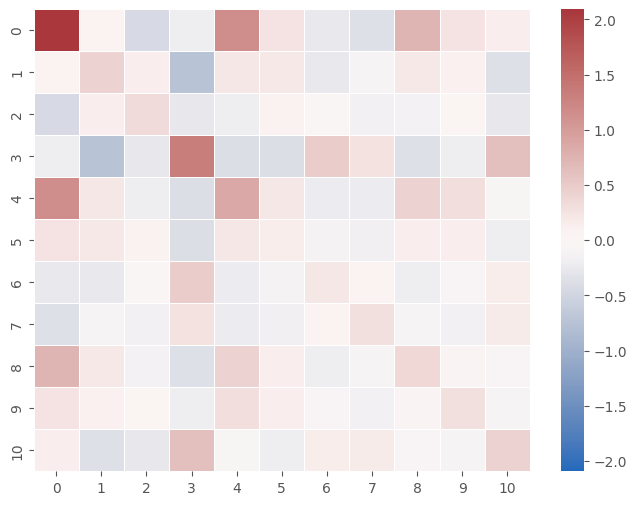

In [12]:
min = np.min(Lambda)
max = np.max(Lambda)
center = (min+max)/2
sns.heatmap(Lambda, annot=False, cmap='vlag', vmax=max, vmin=-max, center=0, linewidth=.5)

In [9]:
def sparsity_degree(L, tol=10e-2):
    return (np.absolute(L.numpy()) < tol).sum() / Lambda.shape[0]**2

In [14]:
sparsity_degree(Lambda, tol=10e-2)

0.9669421487603306

In [48]:
sparsity_degree(tf.linalg.inv(Lambda))

0.0